In [1]:
using Seismic, PyPlot

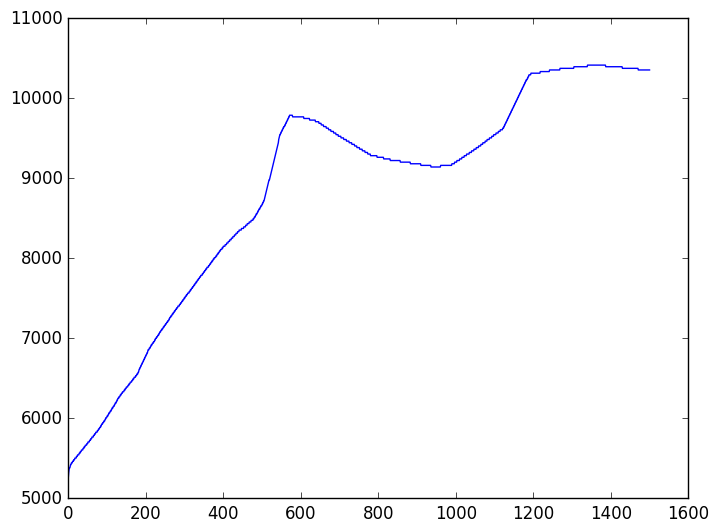

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f26bedc5a90>

In [2]:
# read velocity files
v, v_h = SeisRead("../../dat/vel_trace");
plot(v)

 in depwarn at deprecated.jl:73
 in int at deprecated.jl:50
 in ricker at /home/gram/.julia/v0.4/Seismic/src/Utils/ricker.jl:3
 in include_string at loading.jl:282
 in execute_request_0x535c5df2 at /home/gram/.julia/v0.4/IJulia/src/execute_request.jl:183
 in eventloop at /home/gram/.julia/v0.4/IJulia/src/IJulia.jl:143
 in anonymous at task.jl:447
while loading In[3], in expression starting on line 3
 in depwarn at deprecated.jl:73
 in int at deprecated.jl:50
 in ricker at /home/gram/.julia/v0.4/Seismic/src/Utils/ricker.jl:4
 in include_string at loading.jl:282
 in execute_request_0x535c5df2 at /home/gram/.julia/v0.4/IJulia/src/execute_request.jl:183
 in eventloop at /home/gram/.julia/v0.4/IJulia/src/IJulia.jl:143
 in anonymous at task.jl:447
while loading In[3], in expression starting on line 3


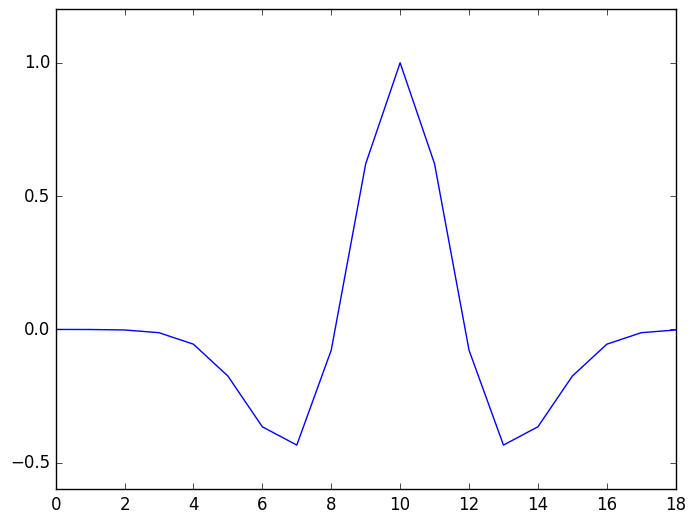

 in depwarn at deprecated.jl:73
 in oldstyle_vcat_warning at ./abstractarray.jl:29
 in ricker at /home/gram/.julia/v0.4/Seismic/src/Utils/ricker.jl:6
 in include_string at loading.jl:282
 in execute_request_0x535c5df2 at /home/gram/.julia/v0.4/IJulia/src/execute_request.jl:183
 in eventloop at /home/gram/.julia/v0.4/IJulia/src/IJulia.jl:143
 in anonymous at task.jl:447
while loading In[3], in expression starting on line 3


1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f26bcb03250>

In [3]:
# create a wavelet
dt = .004
w = ricker(30, dt);

plot(w)

In [4]:
size(w)

(19,)

In [5]:
# set up headers in wavelet file
w_h = Array(Header,1);
w_h[1] = Seismic.InitSeisHeader();
w_h[1].tracenum = 1;
w_h[1].n1 = size(w)[1];
w_h[1].d1 = dt;

ex = Seismic.Extent(convert(Int32,size(w)[1]), convert(Int32,1), 1, 1, 1, 0, 0, 0, 0, 0, convert(Float32,dt), 1, 1, 1, 1, "Depth", "sx", "sy", "", "", "", "", "", "", "", "")

SeisWrite("../dat/wav",w,w_h, ex);

w, w_h = SeisRead("../dat/wav");

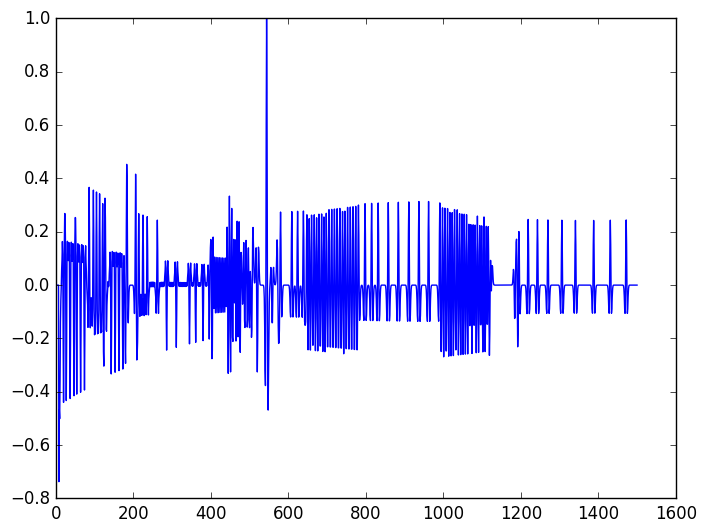

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f26bc3ac790>

In [6]:
# build reflectivity image to model

    # initialize
nz = size(v)[1]
nx = 1
ny = 1
r = zeros(Float32,nz,nx,ny)
d1 = d2 = 1 # acoustic assumption

    # calculate (normal incidence) reflection coeficients
for k = 1 : ny, j = 1 : nx, i = 1 : nz - 1
    r[i,j,k] = ((d2 * v[i+1,j,k] - d1 * v[i,j,k]) / (d2 * v[i+1,j,k] + d1 * v[i,j,k])) ^ 2
end


    # convolve RC with Ricker wavelet to generate 0 offset section
nz_new = size(w)[1] + nz - 1

m = zeros(Float32, nz_new, nx, ny)
for j = 1 : ny, i = 1 : nx
    m[:,i,j] = conv(r[:,i,j], w)
end

# window out middle samples of convolution for physical reality
extra = size(m)[1] - nz
image = zeros(Float32, size(v)[1], 1, 1)

if isodd(extra) == true
    for j = 1 : ny, i = 1 : nx
        image[:,i,j] = m[Int(ceil(extra / 2)) : nz - 1 + Int(ceil(extra / 2)), i, j]
    end
else
    for j = 1 : ny, i = 1 : nx
        image[:,i,j] = m[Int(extra / 2) : nz - 1 + Int(extra / 2), i, j]
    end
end

image[1:8] = 0
image = image / maximum(image)

plot(image[:,:,1])

In [21]:
# make 3D image and vel
im3d = zeros(Float32, size(image)[1], 10000)
vl3d = zeros(Float32, size(image)[1], 10000)

for i = 1 : 1000
    im3d[:,i] = image[:,1,1]
end

for i = 1 : 1000
    vl3d[:,i] = v[:]
end

# set up headers for image file
i_h = Array(Header, 10000)
mx = zeros(Float32, 10000)
my = zeros(Float32, 10000)
idx = 1

for i = 1 : 10000
    mx[i] = idx
    if idx == 100
        idx = 0
    end
    idx += 1
end
idx = 1
for i = 1 : 10000
    my[i] = idx
    if i % 100 == 0
        idx += 1
    end
end

for i = 1 : 10000
    i_h[i] = Seismic.InitSeisHeader();
    i_h[i].tracenum = i;
    i_h[i].n1 = size(image)[1];
    i_h[i].d1 = convert(Float32,dt);
    i_h[i].mx = convert(typeof(v_h[1].mx), mx[i]);
    i_h[i].my = convert(typeof(v_h[1].mx), my[i]);
end

ex = Seismic.Extent(convert(Int32,size(image)[1]), convert(Int32,100), convert(Int32,100), 
        1, 1, 0, 0, 0, 0, 0, convert(Float32,dt), 1, 1, 1, 1, 
        "Depth", "mx", "my", "", "", "", "", "", "", "", "")

SeisWrite("../dat/image", im3d, i_h, ex);
SeisWrite("../dat/vel", vl3d, i_h, ex);

In [22]:
# forward model
ShotProfileWEM("../dat/image", "../dat/shot", vel="../dat/vel", wav="../dat/wav", [adj=false,
        sz=0, gz=0, fmin=0, fmax=50, padt=2, padx=2, nang=1, oang=0, dang=2, naz=1, oaz=0, daz=2, 
        nhx=100, ohx=-50, dhx=10, nhy=1, ohy=0, dhy=2, omp=2, verbose="y",
        sx=[0.0:100.0:0.0], sy=[0.0:100.0:0.0]]);

LoadError: LoadError: error compiling anonymous: error compiling shotwem: could not load library "shotwem"
shotwem: cannot open shared object file: No such file or directory
 in anonymous at multi.jl:1369
 in run_work_thunk at multi.jl:661
 in run_work_thunk at multi.jl:670
 in anonymous at task.jl:58
while loading In[22], in expression starting on line 2